# Illustration of HRP 

## Imports 

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('../')

In [4]:
from typing import List
import datetime
import tqdm
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import yfinance as yf


In [5]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
from opm.hrp.datasets import build_block_matrix
from opm.hrp.datasets import build_true_matrix
from opm.hrp.datasets import covariance2correlation
from opm.hrp.datasets import simulate_covariance_mean

In [7]:
from opm.hrp.ingest import fetch_historical_data_from_yfinance
from opm.hrp.cluster import HierarchicalClustering
from opm.hrp.recursive_bisection import * 
from opm.hrp.quasi_diagonalization import *
from opm.hrp.utils import *

## Synthetic data generation

In [8]:
number_blocks, block_size, block_correlation = 10,50,0.5

In [9]:
np.random.seed(0)

true_mu, true_covariance = build_true_matrix(number_blocks=number_blocks, 
                                             block_size = block_size, 
                                             block_correlation = block_correlation) 

In [10]:
true_covariance.reset_index(drop = True, inplace=True)
true_covariance.columns = true_covariance.index

<AxesSubplot:>

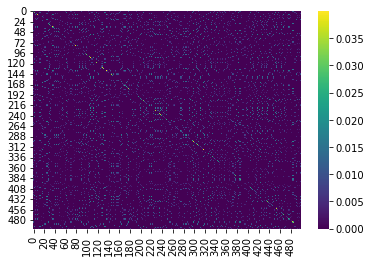

In [11]:
sns.heatmap(true_covariance, cmap = 'viridis')

In [12]:
true_correlation = covariance2correlation(true_covariance)

## HRP

### Hierarchical Clustering 

In [13]:
hierarchical_clustering_model = HierarchicalClustering(is_similarity_matrix=True)

In [14]:
hierarchical_clustering_model.fit(true_correlation)

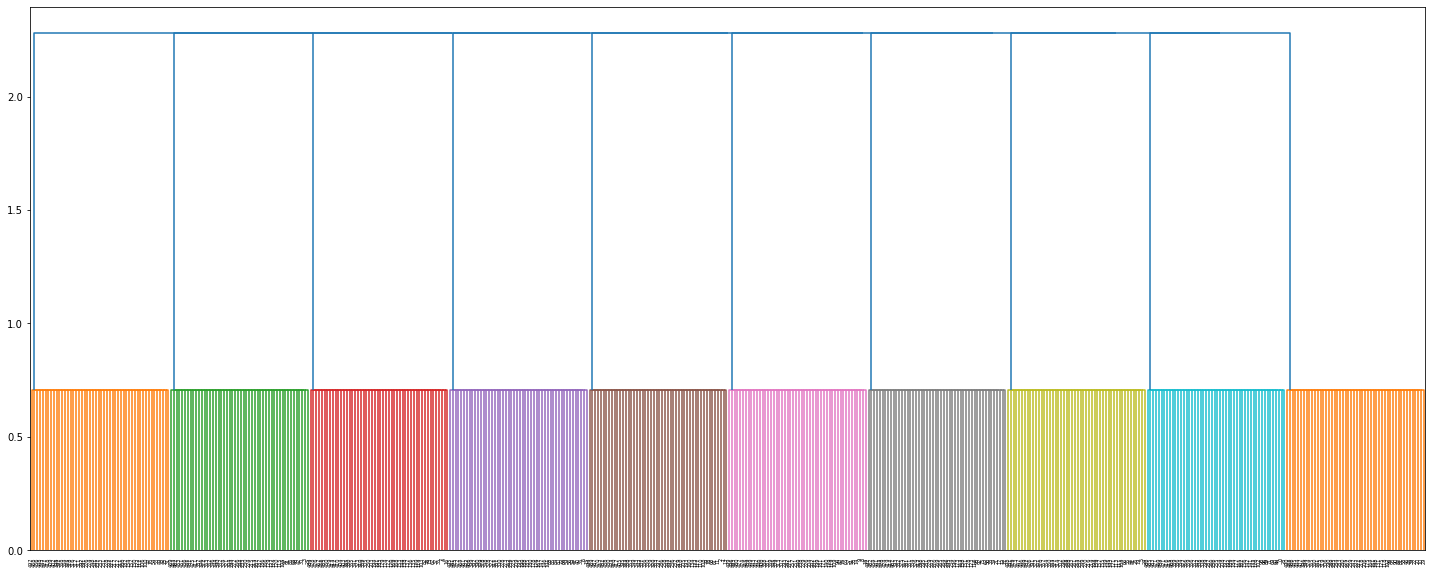

In [15]:
hierarchical_clustering_model.plot_dendrogram()

In [16]:
link = hierarchical_clustering_model.linkage_matrix

In [17]:
column_names = true_correlation.columns.tolist()

### Quasi-diagonalization 

In [18]:
sort_ix = quasi_diagonalize_linkage(link)
column_names = np.array(column_names)


In [19]:
reordered_true_correlation = true_correlation.iloc[column_names[sort_ix]]
reordered_true_correlation = reordered_true_correlation.iloc[:, column_names[sort_ix]]

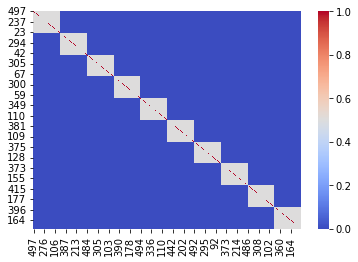

In [20]:
ax = sns.heatmap(reordered_true_correlation, cmap = 'coolwarm') 

### Recursive bi-section

In [21]:
weights_HRP = compute_recursive_bisection_weights(true_correlation, sort_ix)
new_index = [column_names[i] for i in weights_HRP.index]
weights_HRP.index = new_index
weights_HRP.name = "HRP"

In [22]:
weights_HRP

497    0.001948
468    0.001299
456    0.001299
448    0.001212
437    0.001212
         ...   
39     0.001182
22     0.001182
20     0.001182
10     0.001182
29     0.001182
Name: HRP, Length: 500, dtype: float64

## Monte-Carlo based comparison 

In [23]:
number_observations, number_simulations, shrink, min_variance_portfolio = 1000, 1000, False, True 
np.random.seed(0)

In [24]:
markowitz_weights = pd.DataFrame(columns = range(true_covariance.shape[0]),
                                 index = range(number_simulations), 
                                 dtype =float)

hrp_weights = markowitz_weights.copy(deep=True)


In [25]:
for i in range(number_simulations):
    sample_mu, sample_covariance = simulate_covariance_mean(true_mu = true_mu, 
                                                            true_covariance = true_covariance,
                                                            number_of_observations = number_observations,
                                                            shrink = shrink)
    markowitz_weights.loc[i] = get_minimum_variance_portfolio_weights(sample_covariance).flatten()
    sample_correlation = covariance2correlation(pd.DataFrame(sample_covariance))
    
    hierarchical_clustering_model = HierarchicalClustering(is_similarity_matrix=True)
    hierarchical_clustering_model.fit(sample_correlation)
    link = hierarchical_clustering_model.linkage_matrix
    sort_ix = quasi_diagonalize_linkage(link)
    hrp_weights.loc[i] = compute_recursive_bisection_weights(sample_correlation, sort_ix) 
    

In [26]:
true_w = get_minimum_variance_portfolio_weights(true_covariance)
true_w = np.repeat(true_w.T , markowitz_weights.shape[0], axis = 0)

In [27]:
np.mean(((true_w - markowitz_weights ).values.flatten()**2)**.5)

0.0036492684241769676

In [28]:
np.mean(((true_w - hrp_weights ).values.flatten()**2)**.5)

0.00477350497395276